# My Theano Tutorial

## 1.简介

初次接触Theano的时候，完全没有明白为什么要把function的定义搞得这么麻烦。

后来接触到了Tensorflow，突然想起来和Theano好像，在Theano中定义一个function和Tensorflow中跑一个session.run()，简直不要太像。都使用到了feed和fetch的概念。

之前看cs224d的时候，助教把Tensorflow和Numpy进行类比，并说它们的很多架构很像。但上我觉得这是一种误导性的。因为实际上，Theano和Tensorflow都是一种符号计算框架，与其说像Numpy，莫不如说像SymPy。由于是符号运算，所以一些基础的运算，这些框架都要自己实现一遍。这可以给我们提供一个强大的功能，自动求导。

根据链式法则，我们可以通过一个表达式的图模型，自动地推算出导数。大神colah这里又有[一篇博客](http://colah.github.io/posts/2015-08-Backprop/)，再次生动形象地描绘了自动求导的机制。OK，说了这么多废话，接下来通过代码，很多来自[官网](http://deeplearning.net/software/theano/tutorial/)，来对Theano有一个基本的了解。

## 2.basic use

In [2]:
import numpy
import theano
import theano.tensor as T
from theano import function  

Using gpu device 0: GeForce GTX 960M (CNMeM is disabled, cuDNN not available)


定义一个function：

In [3]:
x = T.dscalar('x')
y = T.dscalar('y')
z = x + y
f = function([x, y], z)

In [4]:
f(2, 3)

array(5.0)

解释下，上面的代码中，x，y被称为**符号变量**，dscalar中的d代表类型double，scalar代表数据是标量。其他的组合如下：

- byte: bscalar, bvector, bmatrix, brow, bcol, btensor3, btensor4
- 16-bit integers: wscalar, wvector, wmatrix, wrow, wcol, wtensor3, wtensor4
- 32-bit integers: iscalar, ivector, imatrix, irow, icol, itensor3, itensor4
- 64-bit integers: lscalar, lvector, lmatrix, lrow, lcol, ltensor3, ltensor4
- float: fscalar, fvector, fmatrix, frow, fcol, ftensor3, ftensor4
- double: dscalar, dvector, dmatrix, drow, dcol, dtensor3, dtensor4
- complex: cscalar, cvector, cmatrix, crow, ccol, ctensor3, ctensor4

稍微复杂一点，两个输出：

In [5]:
x = T.dscalar('x')
y = T.dscalar('y')
z = x + y
n_x = -x
f = function([x, y], [z,n_x])

In [6]:
f(2, 3)

[array(5.0), array(-2.0)]

将function以图片的方式输出，需要先安装pydot，graphviz

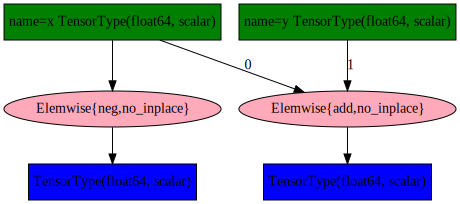

In [7]:
from IPython.display import SVG
SVG(theano.printing.pydotprint(f, return_image=True,
                               format='svg'))

使用In类设置参数的默认值：

In [10]:
from theano import In
x, y, w = T.dscalars('x', 'y', 'w')
z = (x + y) * w
f = function([x, In(y, value=1), In(w, value=2, name='w_by_name')], z)
f(1)

array(4.0)

## 3.共享变量 shared variable
共享变量同样存在于Tensorflow，我认为是一个比较重要的知识点。

tutorial中的解释是：共享变量是符号变量和非符号变量的混合体，它可以在多个function中共享。可以通过get_value和set_value来获取和设置共享变量的值。

你可以像使用其他符号变量一样在表达式中使用共享变量，也可以像使用非符号变量一样，获取共享变量的值。

In [12]:
from theano import shared
state = shared(0)
inc = T.iscalar('inc')
accumulator = function([inc], state, updates=[(state, state+inc)])

这里的function用到了**updates**参数，updates参数使用下面的形式：(shared-variable, new expression)

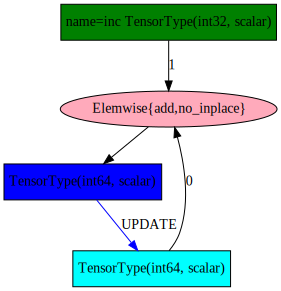

In [13]:
SVG(theano.printing.pydotprint(accumulator, return_image=True,
                               format='svg'))

In [15]:
for i in range(10):
    ans = accumulator(2)
    print ans

0
2
4
6
8
10
12
14
16
18


In [17]:
# 在多个function中使用同一个共享变量
decrementor = function([inc], state, updates=[(state, state-inc)])
for i in range(10):
    ans = decrementor(2)
    print state.get_value()

38
36
34
32
30
28
26
24
22
20


再来看一个function中的重要参数**givens**。givens常常使用在你需要替换掉表达式的某些特定节点，当然替换的对象必须是符号变量或者共享变量。

In [25]:
print "state = ", state.get_value()
fn_of_state = state * 2 + inc
use_shared = function([inc], fn_of_state)
print "state * 2 + inc = ", use_shared(1)

state =  20
state * 2 + inc =  41


上面的fn_of_state定义了一个新的表达式，使用了之前定义的共享变量state。但在这里的应用场景下，我只想再次使用这个表达式，而不是使用共享变量中的值。

In [26]:
foo = T.scalar(dtype=state.dtype)
skip_shared = function([inc, foo], fn_of_state, givens=[(state, foo)])
print "foo * 2 + inc = ", skip_shared(1, 3)  

foo * 2 + inc =  7


## 4. copy函数
我们调用function的copy函数，来拷贝这个function，swap参数可以指定新的共享变量。

In [28]:
new_state = theano.shared(0)
new_accumulator = accumulator.copy(swap={state:new_state})
new_accumulator(100)
print new_state.get_value()

100


## 5. 求导


In [34]:
from theano import pp
x = T.dscalar('x')
y = x ** 2
gy = T.grad(y, x)
pp(gy)

'((fill((x ** TensorConstant{2}), TensorConstant{1.0}) * TensorConstant{2}) * (x ** (TensorConstant{2} - TensorConstant{1})))'

In [37]:
pp(f.maker.fgraph.outputs[0])

'(TensorConstant{2.0} * x)'

In [35]:
f = theano.function([x], gy)
print "gy = 2 * x: ",f(4)

gy = 2 * x:  8.0
